In [1]:
from pathlib import Path
from tqdm import tqdm
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA
from sklearn import preprocessing
import plotly.graph_objects as go

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "data")
products = os.listdir(data_path)
number_of_product = len(products)
number_of_product

15

In [3]:
check_shape = True
check_embeddings = True
check_dist = True

The dataset contains 15 folders for 15 different product. Each folder contain a train set (all good images) and a test set (with different types of defect)

(900, 900, 3)


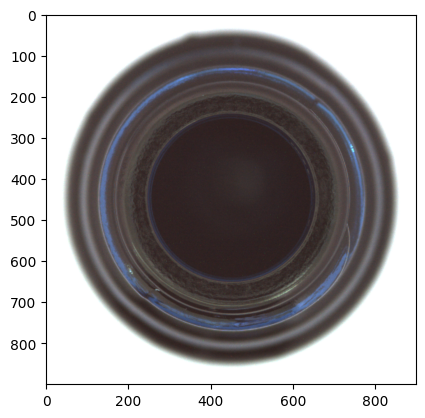

In [4]:
sample_image = cv2.imread("/media/khoa-ys/Personal/Materials/Master's Thesis/image_similarity_assessment/data/bottle/train/000.png", cv2.IMREAD_UNCHANGED)
print(sample_image.shape)
plt.imshow(sample_image)

In [5]:
sample_image.shape
resized_sample_image = cv2.resize(sample_image, (128,128))
resized_sample_image.ravel().shape

(49152,)

### Check image shape

In [6]:
if check_shape:
    train_shape = {}
    test_shape = {}
    for product in products:
        print(product)
        product_path = os.path.join(data_path, product)
        
        train_path = os.path.join(product_path, "train")
        test_path = os.path.join(product_path, "test")
        train_shapes = []
        test_shapes = []
        for image in os.listdir(train_path):
            train_image = cv2.imread(os.path.join(train_path, image), cv2.IMREAD_UNCHANGED)
            train_shapes.append(train_image.shape[:2])
        for case in os.listdir(test_path):
            case_path = os.path.join(test_path, case)
            for image in os.listdir(case_path):
                test_image = cv2.imread(os.path.join(case_path, image), cv2.IMREAD_UNCHANGED)
                test_shapes.append(test_image.shape[:2])
        train_shape[product] = train_shapes
        test_shape[product] = test_shapes
    
    for product in os.listdir(data_path):
        shape_list = train_shape[product] + test_shape[product]
        print(product, np.unique(np.array(shape_list), axis=0))

bottle
cable
capsule
carpet
grid
hazelnut
leather
metal_nut
pill
screw
tile
toothbrush
transistor
wood
zipper
bottle [[900 900]]
cable [[1024 1024]]
capsule [[1000 1000]]
carpet [[1024 1024]]
grid [[1024 1024]]
hazelnut [[1024 1024]]
leather [[1024 1024]]
metal_nut [[700 700]]
pill [[800 800]]
screw [[1024 1024]]
tile [[840 840]]
toothbrush [[1024 1024]]
transistor [[1024 1024]]
wood [[1024 1024]]
zipper [[1024 1024]]


The image of each class have equal square size and 3 channels. The question is do we want to resize them to all at a same size

### Image embeddings

In [ ]:
if check_embeddings:
    labels_dict = {}
    embedded_images_dict = {}
    n_components = 2
    pca = PCA(n_components)
    
    for product in products:
        print(product)
        product_path = os.path.join(data_path, product)
        
        train_path = os.path.join(product_path, "train")
        test_path = os.path.join(product_path, "test")
        
        labels = []
        flattened_images = []
        for image in os.listdir(train_path):
            train_image = cv2.imread(os.path.join(train_path, image), cv2.IMREAD_UNCHANGED)
            resized_train_image = cv2.resize(train_image, (64,64))
            flattened_train_image = resized_train_image.ravel()
            flattened_images.append(flattened_train_image)
    
            labels.append(product + " good")
        for case in os.listdir(test_path):
            if case != 'good':
                case_path = os.path.join(test_path, case)
                for image in os.listdir(case_path):
                    test_image = cv2.imread(os.path.join(case_path, image), cv2.IMREAD_UNCHANGED)
                    resized_test_image = cv2.resize(test_image, (64,64))
                    flattened_test_image = resized_test_image.ravel()
                    flattened_images.append(flattened_test_image)
        
                    labels.append(product + " " + case)
    
        embeddings = pca.fit_transform(flattened_images)
        labels_dict[product] = labels
        embedded_images_dict[product] = embeddings
    
    fig, ax = plt.subplots(5, 3, figsize=(30, 50))
    fig.tight_layout(pad=5)
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    
    label_encoder = preprocessing.LabelEncoder()
    for i in range(number_of_product):
        product = products[i]
    
        embedded_images = embedded_images_dict[product]
        labels = labels_dict[product]
        labels_number = label_encoder.fit_transform(labels)
        
        x, y = (int(i%3), int(i/3))
        scatter = ax[y, x].scatter(embedded_images[:, 0], embedded_images[:, 1], c=labels_number)
        ax[y, x].title.set_text(product)
        ax[y, x].set_xlabel('Principal Component 1')
        ax[y, x].set_ylabel('Principal Component 2')
        ax[y, x].legend(handles=scatter.legend_elements()[0], labels=np.unique(labels).tolist(), loc='upper right')
    fig.show()
    fig.savefig(root_path + '/Figure/each_class_embeddings.png')

bottle
cable
capsule
carpet


### Check train test distribution

In [ ]:
labels_dict = {}

for product in products:
    print(product)
    labels = {}
    product_path = os.path.join(data_path, product)
    
    train_path = os.path.join(product_path, "train")
    test_path = os.path.join(product_path, "test")
    
    labels['good'] = len(os.listdir(train_path))
    
    for case in os.listdir(test_path): 
        case_path = os.path.join(test_path, case)
        if case == 'good':
            labels[case] += len(os.listdir(case_path))
        else:
            labels[case] = len(os.listdir(case_path))
    
    labels_dict[product] = labels

fig, ax = plt.subplots(5, 3, figsize=(30, 50))
fig.tight_layout(pad=5)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
for i in range(number_of_product):
    product = products[i]
    product_count = labels_dict[product]
    labels, count = list(product_count.keys()), list(product_count.values())
    
    x, y = (int(i%3), int(i/3))
    ax[y, x].pie(count, labels=labels, autopct=lambda x: np.round(x/100.*np.sum(count), 0))
    ax[y, x].title.set_text('Class distribution of: '+ product)
    ax[y, x].legend()
fig.show()
fig.savefig(root_path + '/Figure/each_class_distribution.png')